# Porovnání sezónosti na komoditních trzích

Tento notebook analyzuje sezónní vzory na různých komoditních trzích pomocí historických dat z Yahoo Finance.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

## 1. Stáhnout 5 let dat pro vybrané futures (Yahoo Finance)

In [ ]:

symbols = {
    "Soybeans (ZS=F)": "ZS=F",
    "Wheat (ZW=F)": "ZW=F",
    "Corn (ZC=F)": "ZC=F",
}

YEARS = 5

start = (pd.Timestamp.today() - pd.DateOffset(years=YEARS)).date()
end = pd.Timestamp.today().date()

def load_close(ticker: str) -> pd.Series:
    df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False)
    # vybereme jen obchodní dny s Close
    s = df["Close"].dropna().copy()
    s.name = ticker
    return s

series = {name: load_close(tkr) for name, tkr in symbols.items()}

## 2. Pomocné funkce pro sezónní překryv

In [16]:

def seasonal_overlay(s: pd.Series, normalize: str = "none"):
    """
    Vrátí DataFrame tvaru: index = day_of_year (1..366), sloupce = roky,
    hodnoty = cena (příp. normalizovaná).
    normalize:
      - 'none'   : původní cena
      - 'first'  : děleno první hodnotou daného roku (index = 1. den roku) -> relativní změna %
      - 'zscore' : (x - mean_rok) / std_rok
    """
    # accept pd.DataFrame with single column as well
    if isinstance(s, pd.DataFrame):
        if s.shape[1] == 1:
            s = s.iloc[:, 0]
        else:
            raise ValueError("seasonal_overlay očekává jednu sérii (Series nebo jednosloupcový DataFrame).")

    s = s.copy()
    s.index = pd.to_datetime(s.index)

    df = s.to_frame("value")
    df["year"] = df.index.year
    df["doy"]  = df.index.dayofyear

    # Vynecháme 29. únor – nebo ho můžeš interpolovat:
    df = df[~((df.index.month == 2) & (df.index.day == 29))]

    wide = df.pivot_table(index="doy", columns="year", values="value")

    # reindex na kompletní 1..366 aby byly díry (víkendy) jako NaN a mohly se vyplnit/interpolovat
    full_index = range(1, 367)
    wide = wide.reindex(full_index)

    # doplnit chybějící hodnoty lineární interpolací napříč dny (obousměrně)
    wide = wide.interpolate(axis=0, method="linear", limit_direction="both")

    if normalize == "first":
        wide = wide.divide(wide.iloc[0, :], axis=1) * 100.0  # 100 = start roku
    elif normalize == "zscore":
        wide = (wide - wide.mean()) / wide.std()

    return wide

def plot_seasonal(wide: pd.DataFrame, title: str, ylabel: str):
    plt.figure(figsize=(11,6))
    for yr in wide.columns:
        plt.plot(wide.index, wide[yr], linewidth=1, alpha=0.9, label=str(yr))
    plt.title(title)
    plt.xlabel("Den v roce (1..366)")
    plt.ylabel(ylabel)
    # jen pár popisků, ať to není přeplněné:
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels) > 8:
        sel = np.linspace(0, len(labels)-1, 8, dtype=int)
        handles = [handles[i] for i in sel]
        labels  = [labels[i]  for i in sel]
    plt.legend(handles, labels, loc="best", fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_with_avg(wide: pd.DataFrame, title: str, ylabel: str):
    """
    Vykreslí všechny roky z wide + průměr napříč roky.
    """
    plt.figure(figsize=(11,6))
    plt.plot(wide.index, wide, linewidth=0.7, alpha=0.35)
    avg = wide.mean(axis=1)
    plt.plot(avg.index, avg, linewidth=2.2, label="Průměr napříč roky")
    plt.title(title)
    plt.xlabel("Den v roce (1..366)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_timeseries_with_year_lines(s, title: str = "Time series", ylabel: str = "Price", color: str = "blue"):
    """
    Vykreslí časovou řadu s modrými svislými čarami na začátku každého roku (1.1.).
    Přijímá Series nebo jednosloupcový DataFrame.
    """
    if isinstance(s, pd.DataFrame):
        if s.shape[1] == 1:
            s = s.iloc[:, 0]
        else:
            raise ValueError("plot_timeseries_with_year_lines očekává jednu sérii (Series nebo jednosloupcový DataFrame).")

    s = s.copy()
    s.index = pd.to_datetime(s.index)

    fig, ax = plt.subplots(figsize=(11,6))
    ax.plot(s.index, s.values, linewidth=1)

    start = s.index.min()
    end = s.index.max()
    for y in range(start.year + 1, end.year + 1):
        x = pd.Timestamp(f"{y}-01-01")
        if start <= x <= end:
            ax.axvline(x=x, color=color, linestyle="--", linewidth=1, alpha=0.8)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

## Vykreslit pro každou komoditu: (A) absolutní ceny, (B) relativně k 1. dni roku

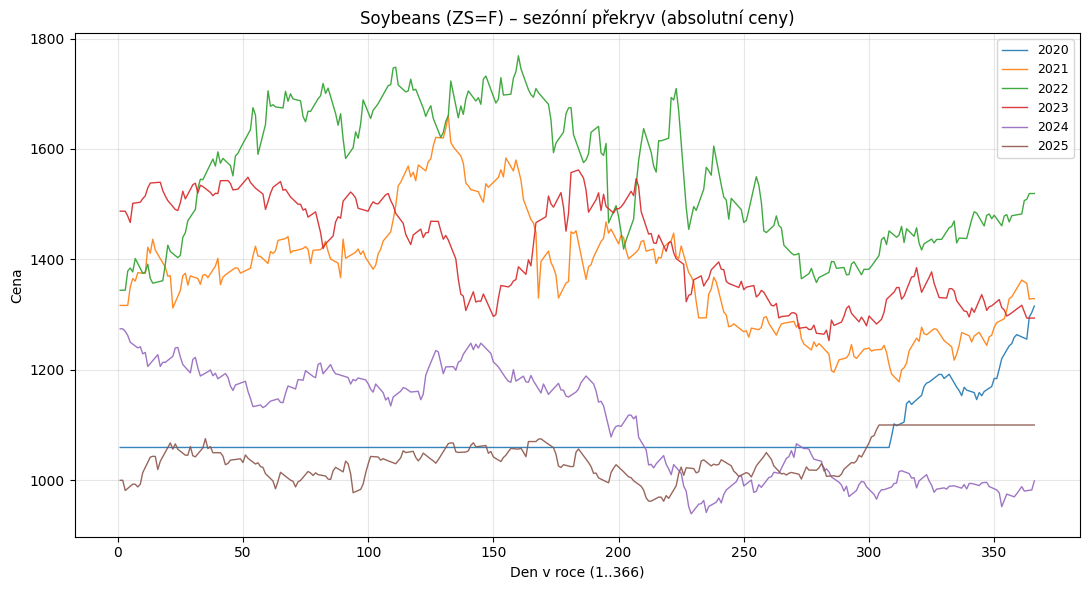

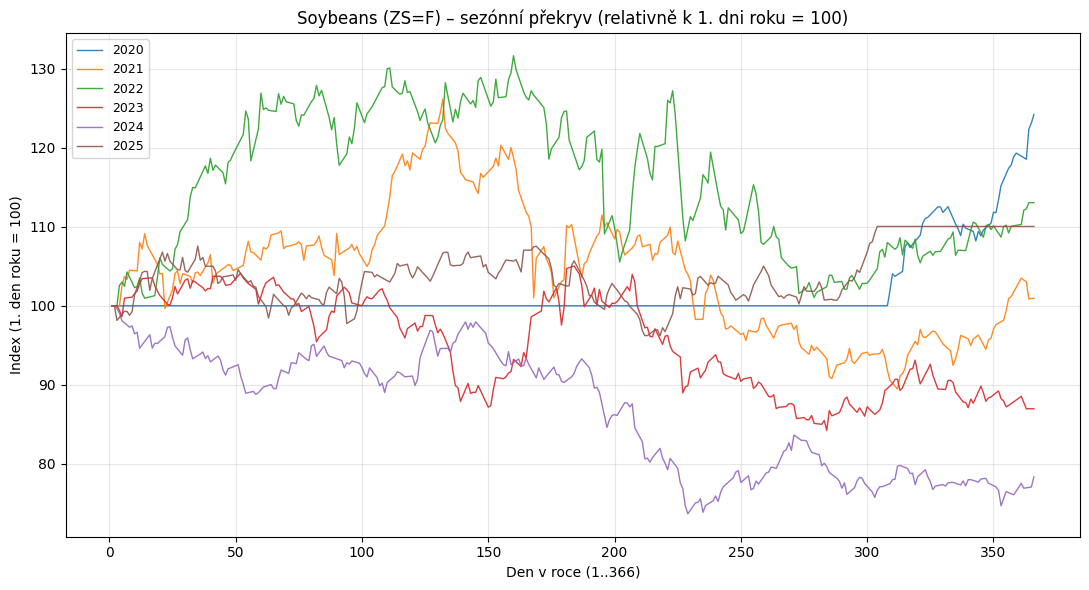

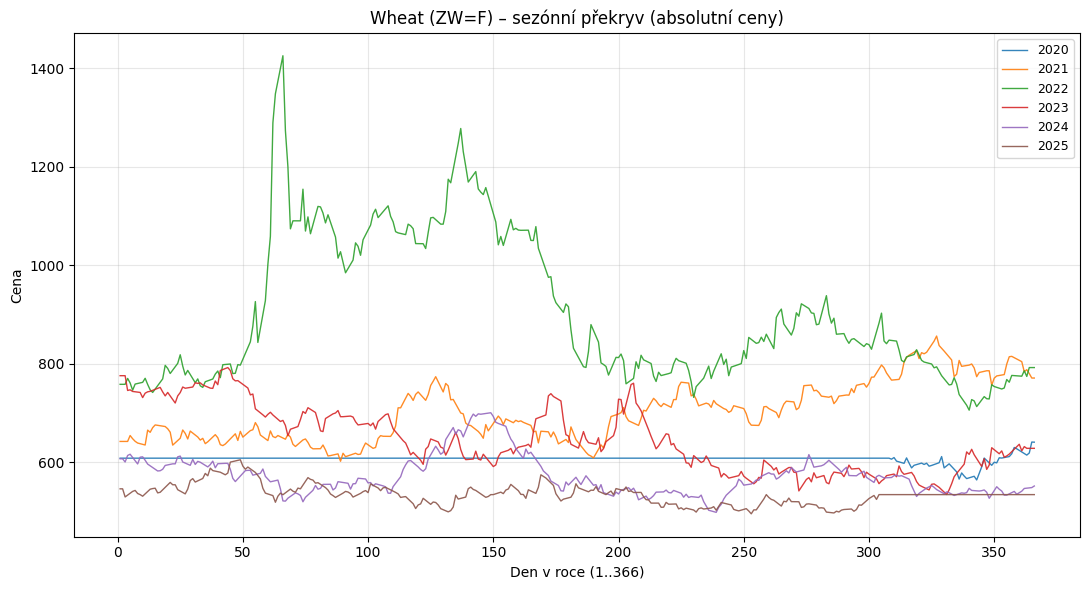

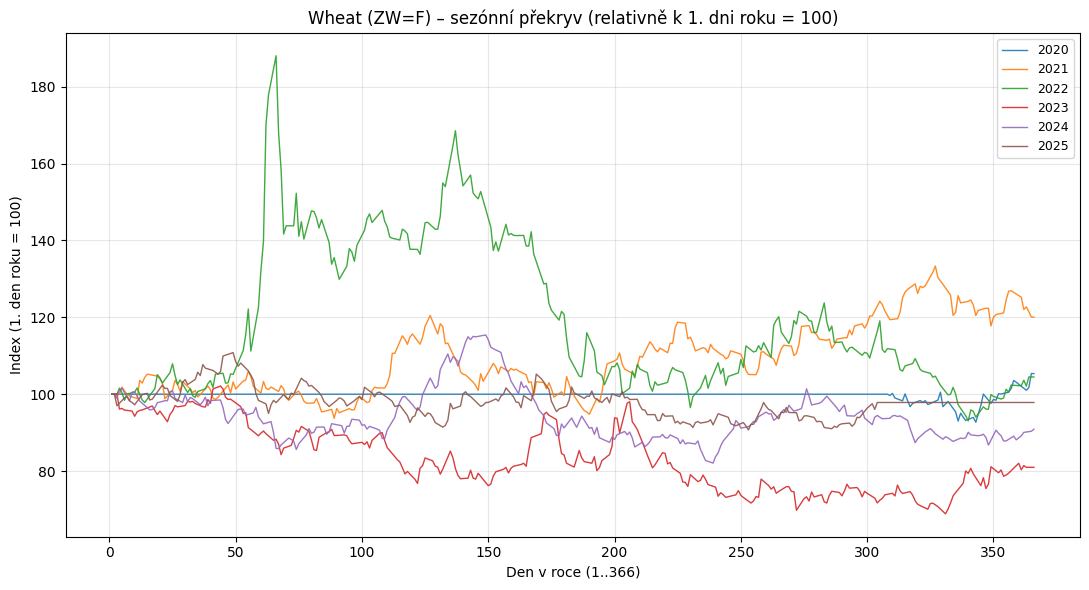

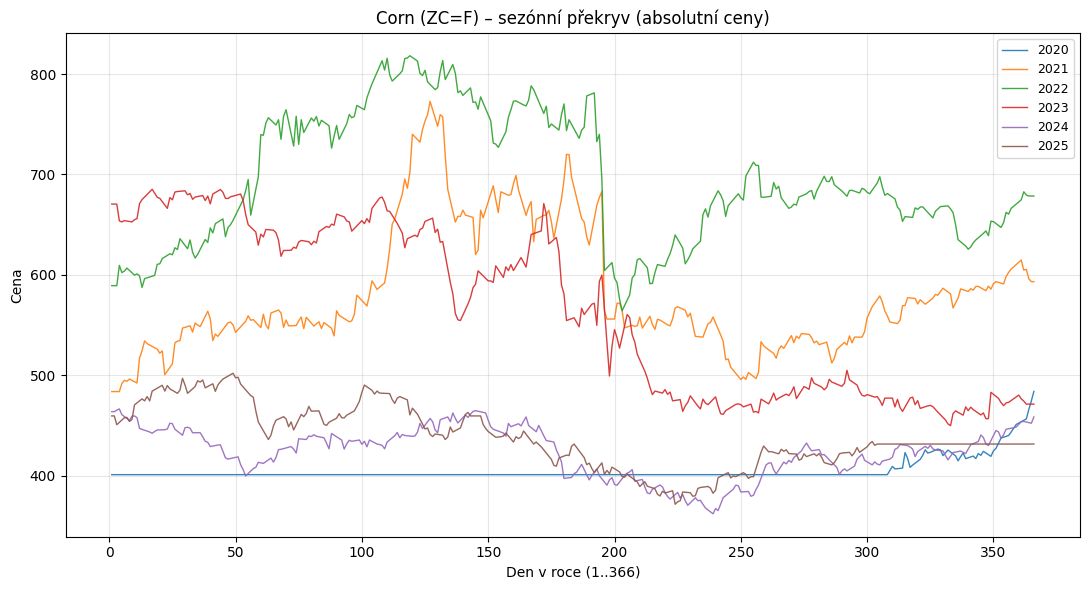

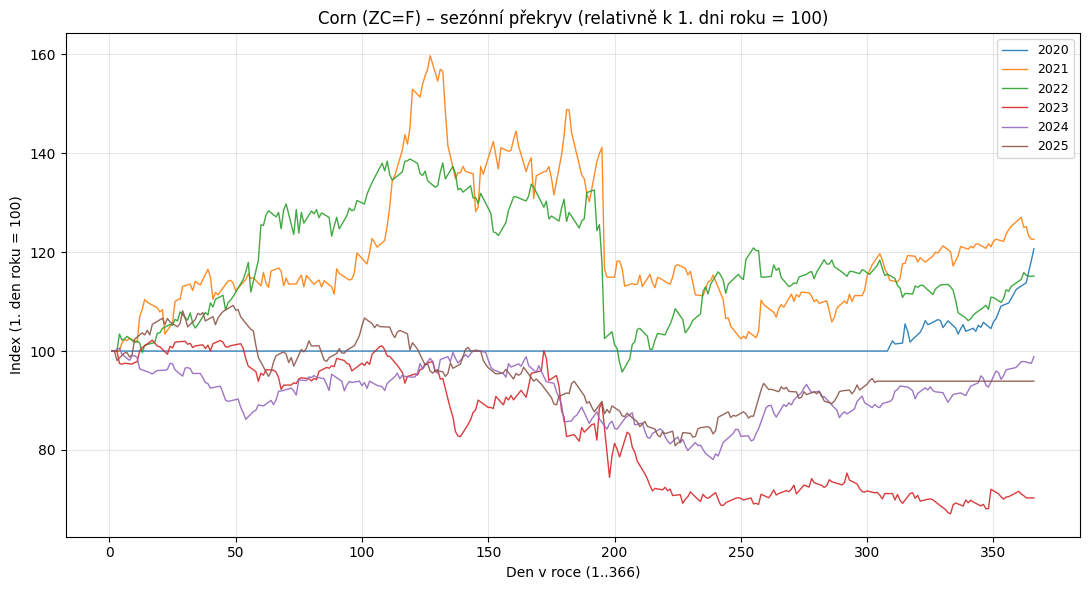

In [17]:
for name, s in series.items():
    # A) absolutní sezónní překryv
    w_abs = seasonal_overlay(s, normalize="none")
    plot_seasonal(w_abs, title=f"{name} – sezónní překryv (absolutní ceny)", ylabel="Cena")

    # B) relativní – procenta od prvního dne každého roku (start=100)
    w_rel = seasonal_overlay(s, normalize="first")
    plot_seasonal(w_rel, title=f"{name} – sezónní překryv (relativně k 1. dni roku = 100)", ylabel="Index (1. den roku = 100)")

In [ ]:
for name, s in series.items():
    w_rel = seasonal_overlay(s, normalize="first")
    plot_with_avg(w_rel, title=f"{name} – průměrná sezónní křivka (relativní)", ylabel="Index (1. den = 100)")